# Pretrained Model Demo - Paper Baseline

This notebook demonstrates the pretrained AE-GMM model used in the paper.

## Overview

This is the **primary demonstration notebook** to quickly verify the model's performance without training from scratch.

**Key Features**:
- Uses the paper's baseline pretrained model (`complete_package_20250914_065942`)
- Works with the included toy dataset (no full dataset download required)
- Shows both Stage 1 (AE) and Stage 2 (AE+GMM) performance
- Includes SHAP explanations for sample predictions

**Model Performance** (from paper):
- F1-Score: 99.1%
- MAE Threshold: 0.135069
- GMM Threshold: 2.741976
- Features: 17 (selected from 90+)

## Requirements

- Python 3.8+
- Dependencies from `requirements.txt`
- Toy dataset (`../data/toy_dataset.csv`) - included in repository

## Output

- Classification reports for Stage 1 and Stage 2
- Confusion matrices
- Score distribution plots
- SHAP waterfall plots explaining predictions

Compare outputs with reference results in `../results/`

---

In [1]:
import sys
from pathlib import Path
base = Path.cwd().parent.parent
sys.path.append(str(base))

In [2]:
import pandas as pd 
import numpy as np

from utils.prepro import load_and_clean, make_balanced_split
from utils.visual import plot_mae_distribution, plot_gmm_score_distribution, plot_confusion_matrices
from utils.evaluation import evaluate_mae, evaluate_gmm, mcnemar_test
from inference.predict_n_explain import batch_predict, predict_and_visualize_single_flow
from inference.load_models_n_explainers import load_complete_package, PicklableShapWrapper
from utils.ignore_non_critical_warnings import suppress_non_critical_warnings

suppress_non_critical_warnings()

c:\Users\PC\Documents\test_clone\ae_gmm_nids\ae_nids_test\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
pkg = load_complete_package(base/'pretrained/complete_package_20250914_065942')

Model package loaded.
AE SHAP explainer loaded.
GMM SHAP explainer loaded.


In [ ]:
# Load the toy dataset (update path if using full dataset)
data = load_and_clean(base/'data/toy_dataset.csv')

Cleaning data...


In [ ]:
df= data   #make_balanced_split(data,ratio_normal_to_intrusions=0.317, total=286000)

Creating balanced dataset with total=286000 and normal:intrusions=0.317...
Attack Type
BENIGN     195338
Anormal     90662
Name: count, dtype: int64


## Batch Prediction

In [6]:
results=batch_predict(pkg, df)

In [7]:
Y_true=df['Attack Type']
rep=evaluate_mae(actual_attack_type=Y_true, mae_scores=results['mae'], threshold_mae=pkg['models']['threshold_mae'])


Classification Report (AutoEncoder Model):
              precision    recall  f1-score   support

     Anomaly       0.96      0.99      0.97     90662
      Normal       0.99      0.98      0.99    195338

    accuracy                           0.98    286000
   macro avg       0.98      0.98      0.98    286000
weighted avg       0.98      0.98      0.98    286000



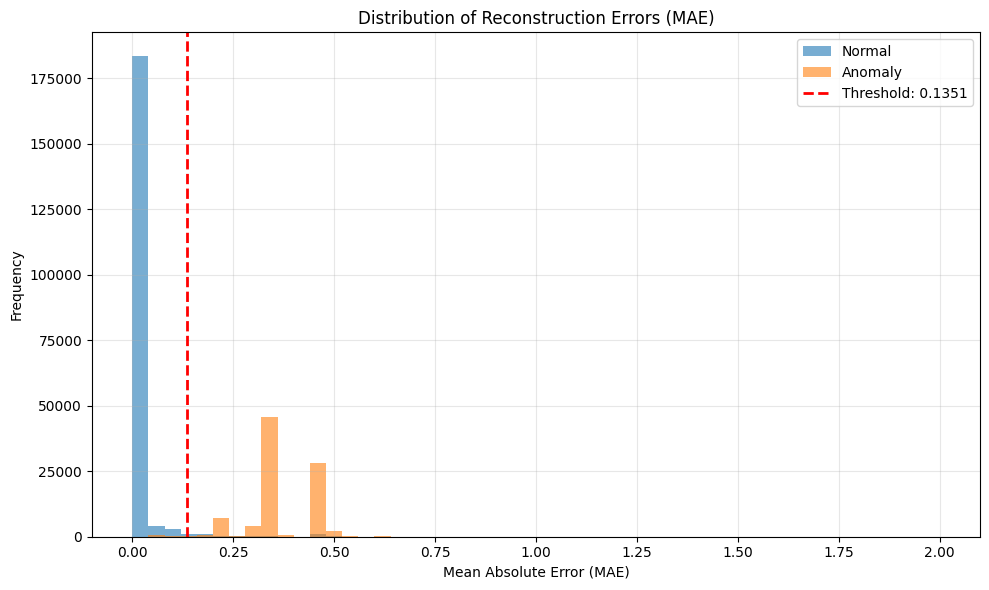

In [8]:
plot_mae_distribution(mae_errors=results['mae'], labels=Y_true, threshold_mae=pkg['models']['threshold_mae'], range_=(0,2))

In [9]:
y_true_enc=pkg['models']['label_encoder'].transform(Y_true) # BENIGN=1, Attack=0

In [10]:
gmm_rep=evaluate_gmm(true_labels_binary=y_true_enc, y_pred_binary=results['anomaly'], class_names=pkg['models']['label_encoder'].classes_)


Classification Report (GMM Model):
              precision    recall  f1-score   support

     Anormal       0.97      1.00      0.99     90662
      BENIGN       1.00      0.99      0.99    195338

    accuracy                           0.99    286000
   macro avg       0.99      0.99      0.99    286000
weighted avg       0.99      0.99      0.99    286000



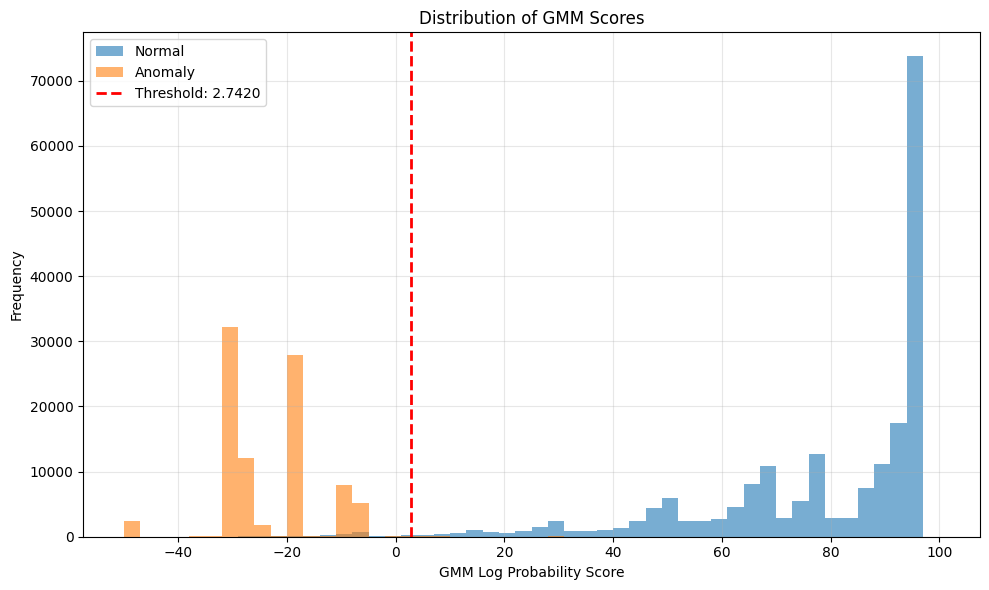

In [11]:
plot_gmm_score_distribution(gmm_scores=results['gmm_score'], labels=Y_true, threshold_gmm=pkg['models']['threshold_gmm'], bins=50, range_=(-50, 100))  

In [12]:
mae_pred_binary = (np.array(results['mae']) < pkg['models']['threshold_mae']).astype(int) # 1=Normal, 0=Anomaly
gmm_pred_binary = results['anomaly']  # 0=Anomaly, 1=Normal

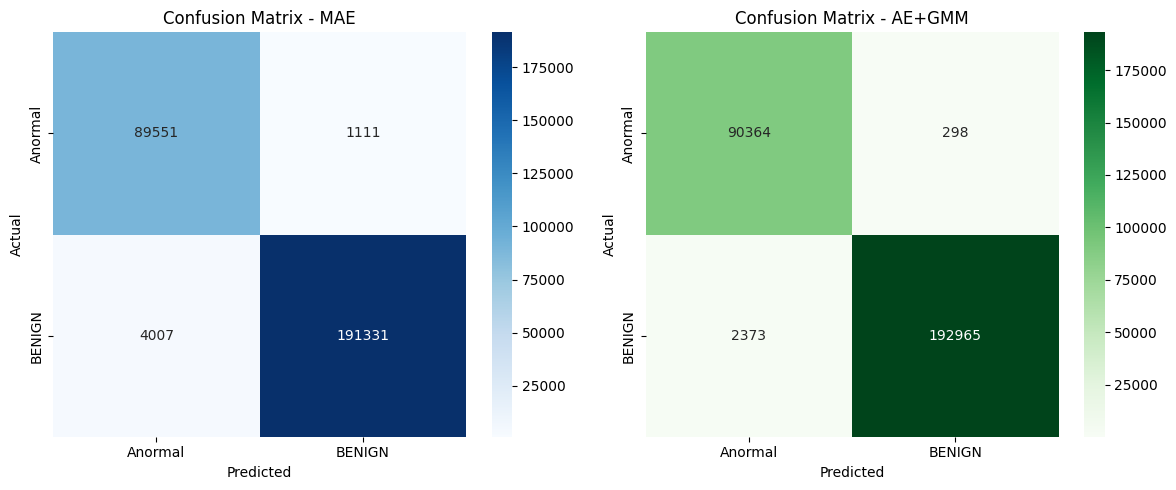

In [13]:
plot_confusion_matrices(y_true_binary=y_true_enc,y_pred_mae_binary=mae_pred_binary,y_pred_gmm_binary=gmm_pred_binary,class_names=pkg['models']['label_encoder'].classes_) 

In [14]:
print(f"Actual binary labels distribution: {np.bincount(y_true_enc)} (0=Anomaly, 1=Normal)")
print(f"MAE-only predicted binary labels distribution: {np.bincount(mae_pred_binary)} (0=Anomaly, 1=Normal)")
print(f"GMM predicted binary labels distribution: {np.bincount(gmm_pred_binary)} (0=Anomaly, 1=Normal)")

Actual binary labels distribution: [ 90662 195338] (0=Anomaly, 1=Normal)
MAE-only predicted binary labels distribution: [ 93558 192442] (0=Anomaly, 1=Normal)
GMM predicted binary labels distribution: [ 92737 193263] (0=Anomaly, 1=Normal)


In [15]:
# Run McNemar’s test
_ = mcnemar_test(y_true_enc, mae_pred_binary, gmm_pred_binary, exact=False, continuity=True)

Contingency table (correctness):
[[280177    705]
 [  3152   1966]]
Off-diagonals: b=705, c=3152
McNemar statistic: 1551.1838, p-value: 0.000000


## Predicting Single Instance
With Shap explainer

In [16]:
test_sample = df.sample(n=1)  # pick a random sample
actual_label = test_sample['Attack Type']
actual_label

4026365    BENIGN
Name: Attack Type, dtype: object

AE-GMM PREDICTION & EXPLANATION 
Final Stage Threshold (GMM Threshold) is 2.741976
Actual Label: BENIGN
Stage 1 (AE MAE) Score: 0.002499
Stage 2 (GMM Score) Score: 77.369587
Final Classification: BENIGN
=== SHAP Explanation Results ===
======== GMM Score SHAP Explanation: =========


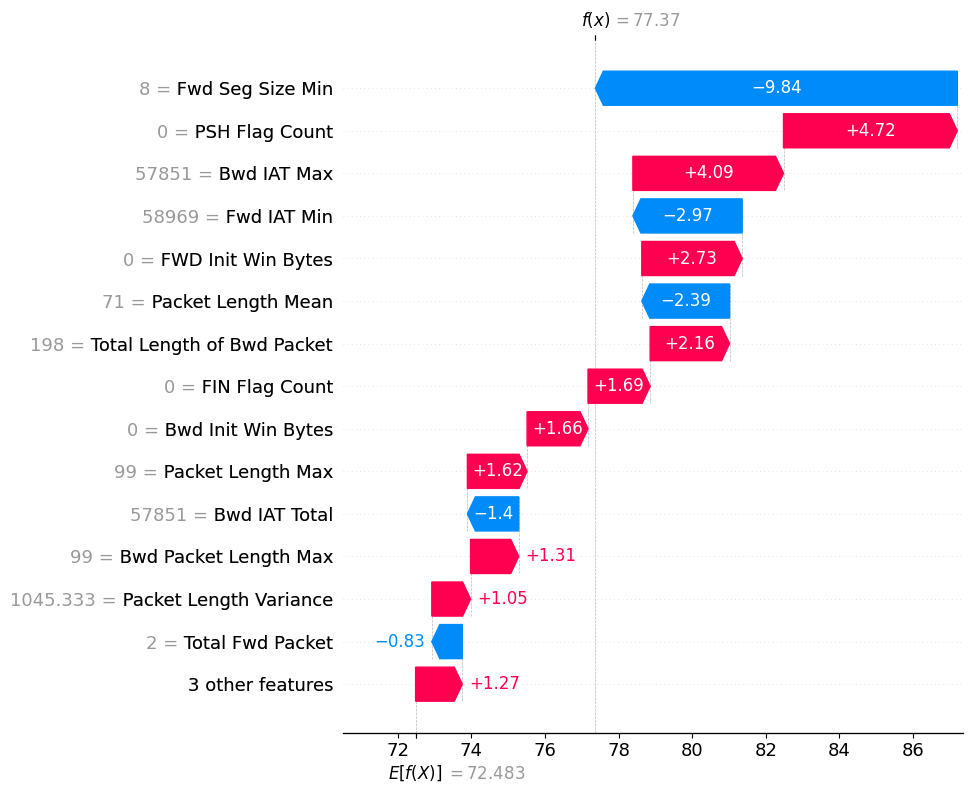

In [17]:
predict_and_visualize_single_flow(pkg, test_sample, actual_label.values[0])